In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [5]:
import splitfolders #or import splitfolders
input_folder = "C:\\Users\\Priyanka Princella\\Desktop\\code_folder\\Data\\Original Images"
output = "withoutaug" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .2, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 228 files [00:00, 252.82 files/s]


In [7]:
train_path = "withoutaug/train"
test_path = "withoutaug/test"


In [8]:
IMAGE_SIZE = [128,128]

In [9]:
#Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

#Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 159 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [14]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet50

In [15]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x = Flatten()(resnet.output)

In [17]:
prediction = Dense(2, activation='softmax')(x)
model1 = Model(inputs = resnet.inputs, outputs = prediction)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [19]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
80/80 [==============================] - 66s 645ms/step - loss: 8.1496 - accuracy: 0.5660 - f1_m: 0.5625 - precision_m: 0.5625 - recall_m: 0.5625 - val_loss: 4.8655 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 2/200
80/80 [==============================] - 51s 642ms/step - loss: 5.2725 - accuracy: 0.5157 - f1_m: 0.5188 - precision_m: 0.5188 - recall_m: 0.5188 - val_loss: 9.7442 - val_accuracy: 0.5797 - val_f1_m: 0.5857 - val_precision_m: 0.5857 - val_recall_m: 0.5857
Epoch 3/200
80/80 [==============================] - 77s 966ms/step - loss: 2.8935 - accuracy: 0.5409 - f1_m: 0.5375 - precision_m: 0.5375 - recall_m: 0.5375 - val_loss: 0.6932 - val_accuracy: 0.5362 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 4/200
80/80 [==============================] - 92s 1s/step - loss: 1.3029 - accuracy: 0.5786 - f1_m: 0.5813 - precision_m: 0.5813 - recall_m: 0.5813 - val_loss: 0.6947 - val_accuracy: 0.4203

In [22]:
res50_acc = hist1.history["val_accuracy"]
res50_prec = hist1.history["val_precision_m"]
res50_rec = hist1.history["val_recall_m"]
res50_f1 = hist1.history["val_f1_m"]

In [25]:
storeResults('ResNet50',res50_acc[0],res50_prec[0],res50_rec[0],res50_f1[0])

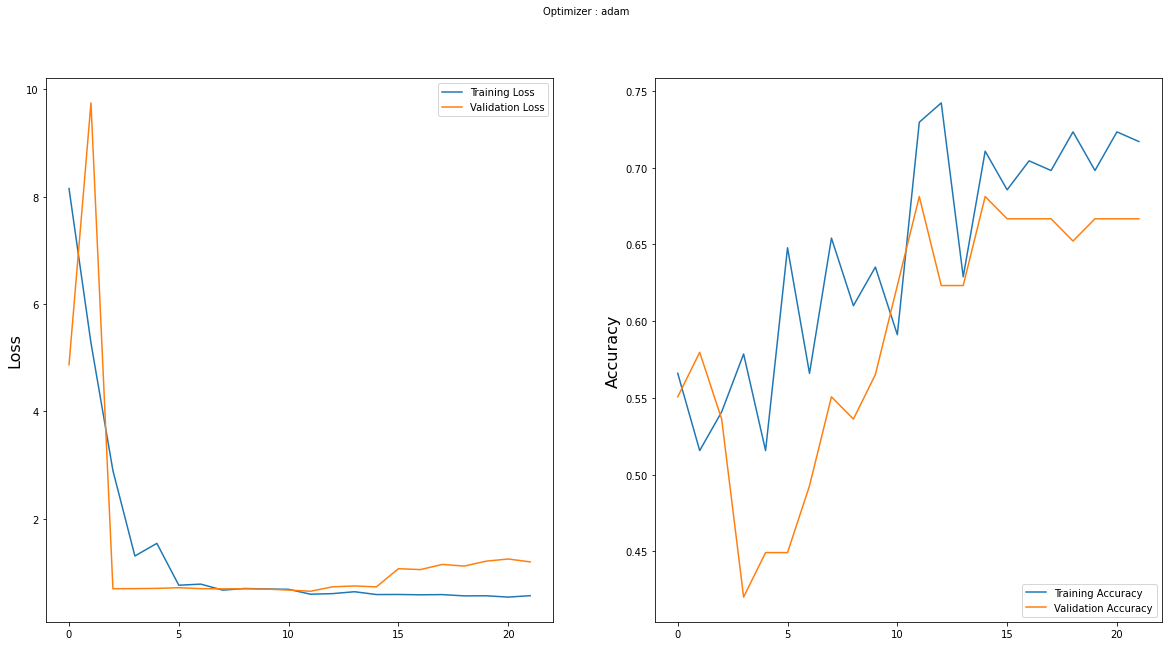

In [26]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# VGG16

In [27]:
vgg16=VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 13s 0us/step


In [28]:
x1= Flatten()(vgg16.output)
prediction1 = Dense(2, activation='softmax')(x1)
model2 = Model(inputs = vgg16.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [29]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
80/80 [==============================] - 76s 878ms/step - loss: 5.9395 - accuracy: 0.5031 - f1_m: 0.5000 - precision_m: 0.5000 - recall_m: 0.5000 - val_loss: 0.7133 - val_accuracy: 0.4493 - val_f1_m: 0.4429 - val_precision_m: 0.4429 - val_recall_m: 0.4429
Epoch 2/200
80/80 [==============================] - 71s 883ms/step - loss: 0.7509 - accuracy: 0.4843 - f1_m: 0.4875 - precision_m: 0.4875 - recall_m: 0.4875 - val_loss: 0.7010 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 3/200
80/80 [==============================] - 101s 1s/step - loss: 0.7236 - accuracy: 0.4906 - f1_m: 0.4938 - precision_m: 0.4938 - recall_m: 0.4938 - val_loss: 0.6880 - val_accuracy: 0.5507 - val_f1_m: 0.5571 - val_precision_m: 0.5571 - val_recall_m: 0.5571
Epoch 4/200
80/80 [==============================] - 106s 1s/step - loss: 0.7016 - accuracy: 0.5409 - f1_m: 0.5437 - precision_m: 0.5437 - recall_m: 0.5437 - val_loss: 0.6880 - val_accuracy: 0.5507 

In [30]:
vgg_acc = hist2.history["val_accuracy"][10]
vgg_prec = hist2.history["val_precision_m"][10]
vgg_rec = hist2.history["val_recall_m"][10]
vgg_f1 = hist2.history["val_f1_m"][10]

In [32]:
storeResults('VGG16',vgg_acc,vgg_prec,vgg_rec,vgg_f1)

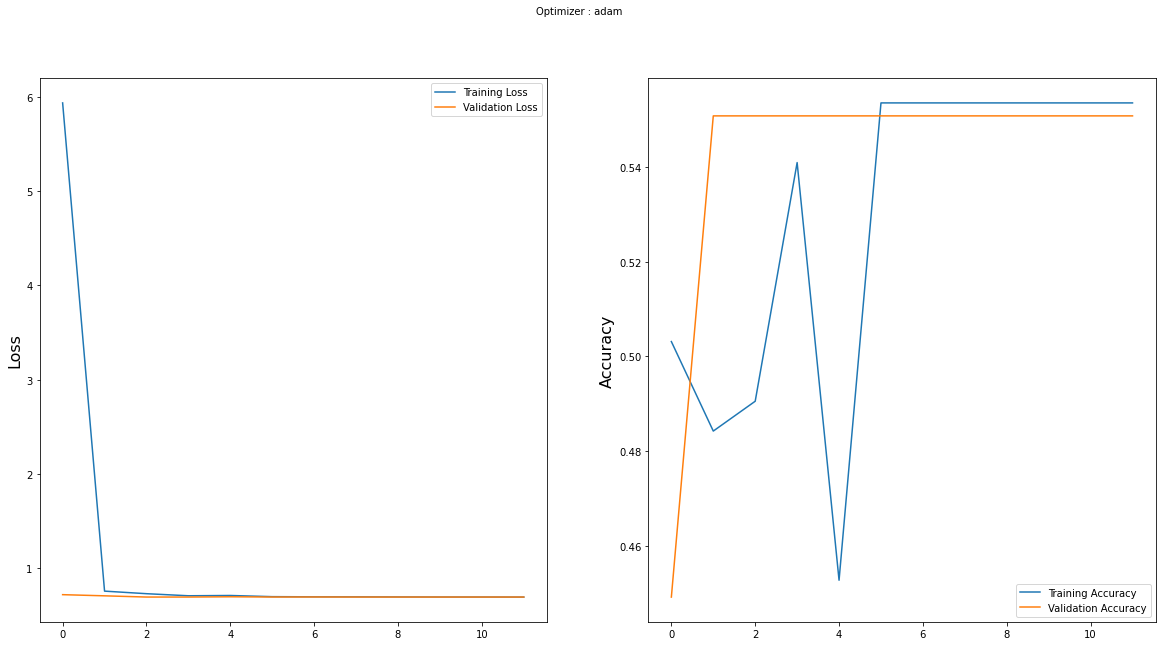

In [33]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Inception ResNetV2

In [34]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [35]:
mob1 = InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

219062272/219055592 [==============================] - 44s 0us/step


In [36]:
x1= Flatten()(mob1.output)
prediction1 = Dense(2, activation='softmax')(x1)
model3 = Model(inputs = mob1.inputs, outputs = prediction1)
model3.summary()
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

batch_normalization_63 (BatchNo (None, 13, 13, 32)   96          conv2d_63[0][0]                  
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 13, 13, 32)   0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 13, 13, 32)   10240       block35_8_ac[0][0]               
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 13, 13, 48)   13824       activation_63[0][0]              
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 13, 13, 32)   96          conv2d_61[0][0]                  
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
block17_5 (Lambda)              (None, 6, 6, 1088)   0           block17_4_ac[0][0]               
                                                                 block17_5_conv[0][0]             
__________________________________________________________________________________________________
block17_5_ac (Activation)       (None, 6, 6, 1088)   0           block17_5[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 6, 6, 128)    139264      block17_5_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 6, 6, 128)    384         conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation

conv2d_160 (Conv2D)             (None, 6, 6, 256)    278528      block17_20_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 6, 6, 256)    768         conv2d_160[0][0]                 
__________________________________________________________________________________________________
activation_160 (Activation)     (None, 6, 6, 256)    0           batch_normalization_160[0][0]    
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 6, 6, 256)    278528      block17_20_ac[0][0]              
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 6, 6, 256)    278528      block17_20_ac[0][0]              
__________________________________________________________________________________________________
conv2d_161

__________________________________________________________________________________________________
conv_7b_ac (Activation)         (None, 2, 2, 1536)   0           conv_7b_bn[0][0]                 
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 6144)         0           conv_7b_ac[0][0]                 
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            12290       flatten_2[0][0]                  
Total params: 54,349,026
Trainable params: 54,288,482
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [37]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
80/80 [==============================] - 240s 2s/step - loss: 2.2922 - accuracy: 0.5283 - f1_m: 0.5250 - precision_m: 0.5250 - recall_m: 0.5250 - val_loss: 1.3751 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 2/200
80/80 [==============================] - 126s 2s/step - loss: 0.9409 - accuracy: 0.5786 - f1_m: 0.5813 - precision_m: 0.5813 - recall_m: 0.5813 - val_loss: 0.6606 - val_accuracy: 0.6087 - val_f1_m: 0.6000 - val_precision_m: 0.6000 - val_recall_m: 0.6000
Epoch 3/200
80/80 [==============================] - 125s 2s/step - loss: 0.9572 - accuracy: 0.5786 - f1_m: 0.5750 - precision_m: 0.5750 - recall_m: 0.5750 - val_loss: 0.6514 - val_accuracy: 0.7391 - val_f1_m: 0.7429 - val_precision_m: 0.7429 - val_recall_m: 0.7429
Epoch 4/200
80/80 [==============================] - 133s 2s/step - loss: 0.8668 - accuracy: 0.6541 - f1_m: 0.6562 - precision_m: 0.6562 - recall_m: 0.6562 - val_loss: 1.9346 - val_accuracy: 0.6522 - va

In [24]:
incres_acc = hist3.history["val_accuracy"][12]
incres_prec = hist3.history["val_precision_m"][12]
incres_rec = hist3.history["val_recall_m"][12]
incres_f1 = hist3.history["val_f1_m"][12]

In [25]:
storeResults('Inception ResNetV2',incres_acc,incres_prec,incres_rec,incres_f1)

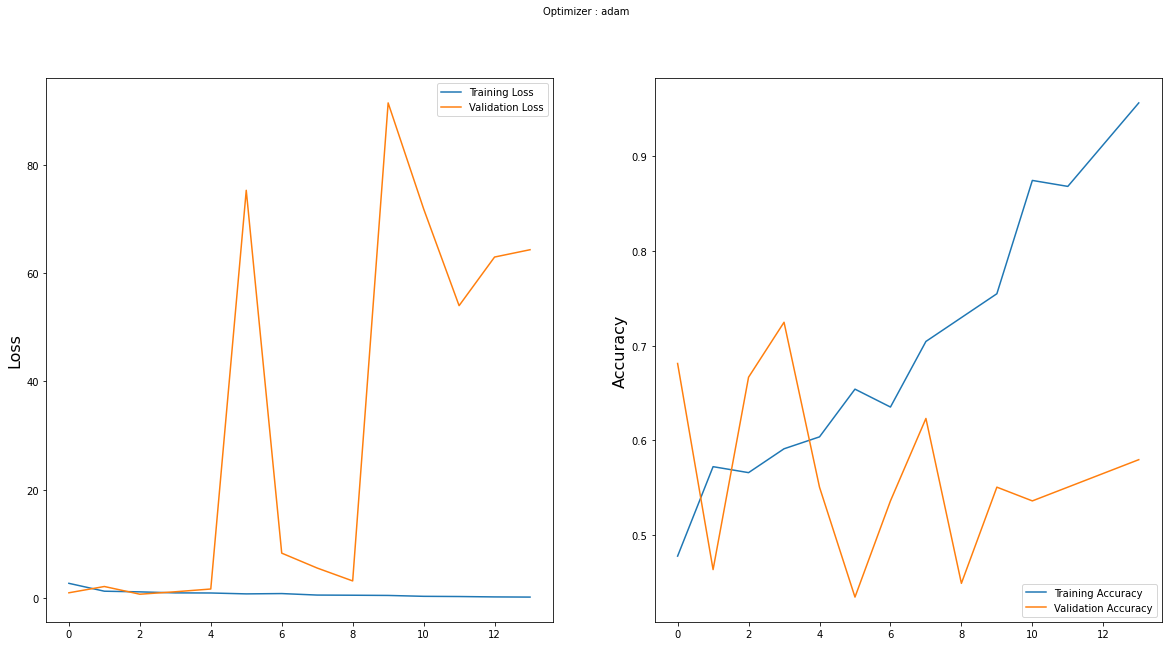

In [23]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet201

In [24]:
from tensorflow.keras.applications import DenseNet201

In [25]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [26]:
x1= Flatten()(des201.output)
prediction1 = Dense(2, activation='softmax')(x1)
model4 = Model(inputs = des201.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [27]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/200
80/80 [==============================] - 63s 541ms/step - loss: 5.9462 - accuracy: 0.5220 - f1_m: 0.5188 - precision_m: 0.5188 - recall_m: 0.5188 - val_loss: 40420.1602 - val_accuracy: 0.4493 - val_f1_m: 0.4571 - val_precision_m: 0.4571 - val_recall_m: 0.4571
Epoch 2/200
80/80 [==============================] - 33s 409ms/step - loss: 6.3576 - accuracy: 0.5094 - f1_m: 0.5063 - precision_m: 0.5063 - recall_m: 0.5063 - val_loss: 4352.9902 - val_accuracy: 0.4493 - val_f1_m: 0.4429 - val_precision_m: 0.4429 - val_recall_m: 0.4429
Epoch 3/200
80/80 [==============================] - 32s 404ms/step - loss: 4.3750 - accuracy: 0.5283 - f1_m: 0.5250 - precision_m: 0.5250 - recall_m: 0.5250 - val_loss: 23940.0078 - val_accuracy: 0.5362 - val_f1_m: 0.5286 - val_precision_m: 0.5286 - val_recall_m: 0.5286
Epoch 4/200
80/80 [==============================] - 32s 404ms/step - loss: 3.0813 - accuracy: 0.5031 - f1_m: 0.5063 - precision_m: 0.5063 - recall_m: 0.5063 - val_loss: 41.8157 - val_a

80/80 [==============================] - 33s 411ms/step - loss: 0.3294 - accuracy: 0.8679 - f1_m: 0.8687 - precision_m: 0.8687 - recall_m: 0.8687 - val_loss: 1.1718 - val_accuracy: 0.5797 - val_f1_m: 0.5857 - val_precision_m: 0.5857 - val_recall_m: 0.5857
Epoch 62/200
80/80 [==============================] - 33s 408ms/step - loss: 0.3092 - accuracy: 0.8679 - f1_m: 0.8625 - precision_m: 0.8625 - recall_m: 0.8625 - val_loss: 1.5242 - val_accuracy: 0.5362 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 63/200
80/80 [==============================] - 33s 408ms/step - loss: 0.4369 - accuracy: 0.8553 - f1_m: 0.8500 - precision_m: 0.8500 - recall_m: 0.8500 - val_loss: 1.5926 - val_accuracy: 0.5797 - val_f1_m: 0.5857 - val_precision_m: 0.5857 - val_recall_m: 0.5857
Epoch 64/200
80/80 [==============================] - 32s 406ms/step - loss: 0.2584 - accuracy: 0.8805 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 1.1662 - val_accuracy: 0.5797 - val

80/80 [==============================] - 34s 429ms/step - loss: 0.0261 - accuracy: 0.9937 - f1_m: 0.9937 - precision_m: 0.9937 - recall_m: 0.9937 - val_loss: 2.1294 - val_accuracy: 0.5797 - val_f1_m: 0.5714 - val_precision_m: 0.5714 - val_recall_m: 0.5714
Epoch 122/200
80/80 [==============================] - 34s 428ms/step - loss: 0.0236 - accuracy: 0.9937 - f1_m: 0.9937 - precision_m: 0.9937 - recall_m: 0.9937 - val_loss: 2.2926 - val_accuracy: 0.5507 - val_f1_m: 0.5571 - val_precision_m: 0.5571 - val_recall_m: 0.5571
Epoch 123/200
80/80 [==============================] - 33s 412ms/step - loss: 0.1221 - accuracy: 0.9560 - f1_m: 0.9563 - precision_m: 0.9563 - recall_m: 0.9563 - val_loss: 1.4297 - val_accuracy: 0.6667 - val_f1_m: 0.6571 - val_precision_m: 0.6571 - val_recall_m: 0.6571
Epoch 124/200
80/80 [==============================] - 33s 408ms/step - loss: 0.2631 - accuracy: 0.9182 - f1_m: 0.9187 - precision_m: 0.9187 - recall_m: 0.9187 - val_loss: 2.6983 - val_accuracy: 0.5652 - 

80/80 [==============================] - 33s 409ms/step - loss: 0.1920 - accuracy: 0.9434 - f1_m: 0.9438 - precision_m: 0.9438 - recall_m: 0.9438 - val_loss: 2.4267 - val_accuracy: 0.6812 - val_f1_m: 0.6714 - val_precision_m: 0.6714 - val_recall_m: 0.6714
Epoch 182/200
80/80 [==============================] - 33s 410ms/step - loss: 0.0422 - accuracy: 0.9811 - f1_m: 0.9812 - precision_m: 0.9812 - recall_m: 0.9812 - val_loss: 3.9500 - val_accuracy: 0.5362 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 183/200
80/80 [==============================] - 33s 416ms/step - loss: 0.0166 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.1272 - val_accuracy: 0.6377 - val_f1_m: 0.6286 - val_precision_m: 0.6286 - val_recall_m: 0.6286
Epoch 184/200
80/80 [==============================] - 34s 427ms/step - loss: 0.0310 - accuracy: 0.9874 - f1_m: 0.9875 - precision_m: 0.9875 - recall_m: 0.9875 - val_loss: 2.1501 - val_accuracy: 0.6087 - 

In [26]:
den_acc = hist4.history["val_accuracy"][199]
den_prec = hist4.history["val_precision_m"][199]
den_rec = hist4.history["val_recall_m"][199]
den_f1 = hist4.history["val_f1_m"][199]

In [27]:
storeResults('DenseNet201',den_acc,den_prec,den_rec,den_f1)

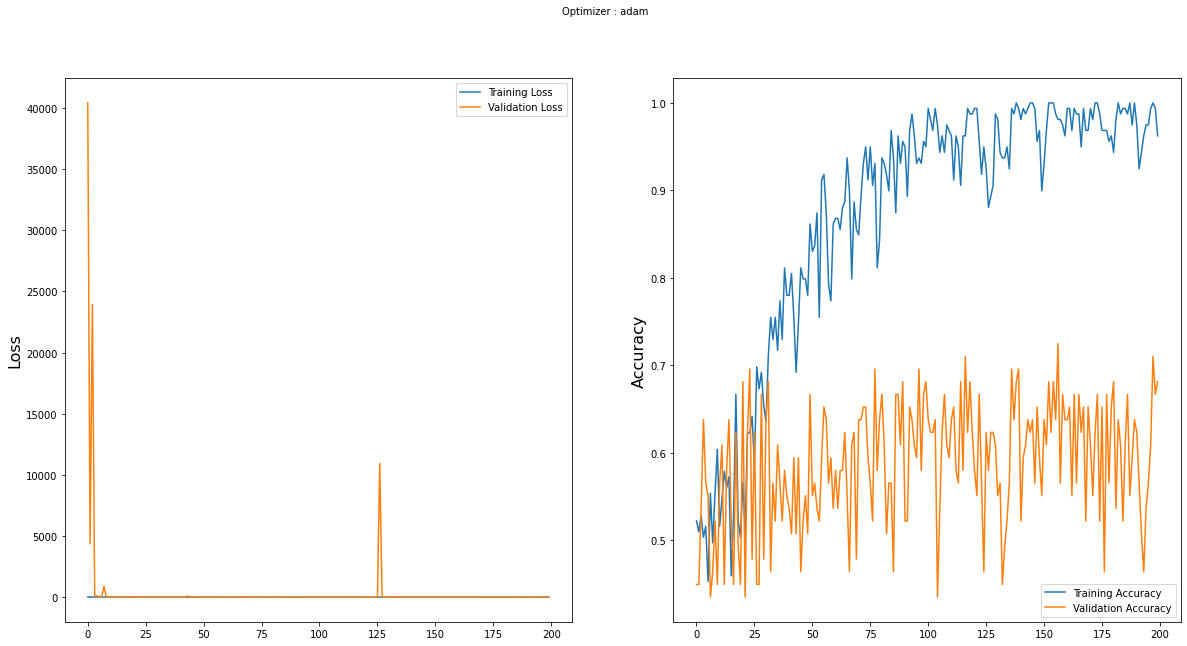

In [28]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3

In [29]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = InceptionV3(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [30]:
predictions = Dense(2, activation='softmax')(x2)

# this is the model we will train
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 63, 63, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 63, 63, 32)   0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [31]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/200
80/80 [==============================] - 22s 186ms/step - loss: 1.3833 - accuracy: 0.5031 - f1_m: 0.5063 - precision_m: 0.5063 - recall_m: 0.5063 - val_loss: 2.4687 - val_accuracy: 0.5652 - val_f1_m: 0.5714 - val_precision_m: 0.5714 - val_recall_m: 0.5714
Epoch 2/200
80/80 [==============================] - 11s 134ms/step - loss: 0.9569 - accuracy: 0.5597 - f1_m: 0.5625 - precision_m: 0.5625 - recall_m: 0.5625 - val_loss: 250.2831 - val_accuracy: 0.5362 - val_f1_m: 0.5286 - val_precision_m: 0.5286 - val_recall_m: 0.5286
Epoch 3/200
80/80 [==============================] - 11s 139ms/step - loss: 0.8157 - accuracy: 0.5472 - f1_m: 0.5437 - precision_m: 0.5437 - recall_m: 0.5437 - val_loss: 30.6437 - val_accuracy: 0.4638 - val_f1_m: 0.4571 - val_precision_m: 0.4571 - val_recall_m: 0.4571
Epoch 4/200
80/80 [==============================] - 11s 142ms/step - loss: 0.8118 - accuracy: 0.4969 - f1_m: 0.4938 - precision_m: 0.4938 - recall_m: 0.4938 - val_loss: 4.4940 - val_accuracy: 

80/80 [==============================] - 11s 135ms/step - loss: 0.7199 - accuracy: 0.5094 - f1_m: 0.5125 - precision_m: 0.5125 - recall_m: 0.5125 - val_loss: 2.2739 - val_accuracy: 0.4493 - val_f1_m: 0.4571 - val_precision_m: 0.4571 - val_recall_m: 0.4571
Epoch 62/200
80/80 [==============================] - 11s 132ms/step - loss: 0.7423 - accuracy: 0.4780 - f1_m: 0.4750 - precision_m: 0.4750 - recall_m: 0.4750 - val_loss: 14.6151 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 63/200
80/80 [==============================] - 11s 136ms/step - loss: 0.7131 - accuracy: 0.5409 - f1_m: 0.5437 - precision_m: 0.5437 - recall_m: 0.5437 - val_loss: 38.5863 - val_accuracy: 0.5362 - val_f1_m: 0.5286 - val_precision_m: 0.5286 - val_recall_m: 0.5286
Epoch 64/200
80/80 [==============================] - 11s 132ms/step - loss: 0.6898 - accuracy: 0.5660 - f1_m: 0.5687 - precision_m: 0.5688 - recall_m: 0.5688 - val_loss: 48.7705 - val_accuracy: 0.5507 - 

80/80 [==============================] - 10s 130ms/step - loss: 0.7338 - accuracy: 0.5283 - f1_m: 0.5250 - precision_m: 0.5250 - recall_m: 0.5250 - val_loss: 222.8851 - val_accuracy: 0.4928 - val_f1_m: 0.4857 - val_precision_m: 0.4857 - val_recall_m: 0.4857
Epoch 122/200
80/80 [==============================] - 11s 133ms/step - loss: 0.7061 - accuracy: 0.5472 - f1_m: 0.5500 - precision_m: 0.5500 - recall_m: 0.5500 - val_loss: 105.0946 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 123/200
80/80 [==============================] - 11s 132ms/step - loss: 0.7092 - accuracy: 0.5346 - f1_m: 0.5312 - precision_m: 0.5312 - recall_m: 0.5312 - val_loss: 431.2541 - val_accuracy: 0.5507 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 124/200
80/80 [==============================] - 10s 130ms/step - loss: 0.7027 - accuracy: 0.5472 - f1_m: 0.5500 - precision_m: 0.5500 - recall_m: 0.5500 - val_loss: 97.2855 - val_accuracy: 0.

80/80 [==============================] - 10s 131ms/step - loss: 0.6938 - accuracy: 0.5409 - f1_m: 0.5437 - precision_m: 0.5437 - recall_m: 0.5437 - val_loss: 211.9564 - val_accuracy: 0.5362 - val_f1_m: 0.5429 - val_precision_m: 0.5429 - val_recall_m: 0.5429
Epoch 182/200
80/80 [==============================] - 11s 132ms/step - loss: 0.7145 - accuracy: 0.5409 - f1_m: 0.5437 - precision_m: 0.5437 - recall_m: 0.5437 - val_loss: 1428.9487 - val_accuracy: 0.5217 - val_f1_m: 0.5286 - val_precision_m: 0.5286 - val_recall_m: 0.5286
Epoch 183/200
80/80 [==============================] - 10s 130ms/step - loss: 0.7231 - accuracy: 0.5094 - f1_m: 0.5063 - precision_m: 0.5063 - recall_m: 0.5063 - val_loss: 512.0538 - val_accuracy: 0.5507 - val_f1_m: 0.5571 - val_precision_m: 0.5571 - val_recall_m: 0.5571
Epoch 184/200
80/80 [==============================] - 11s 132ms/step - loss: 0.6996 - accuracy: 0.5346 - f1_m: 0.5375 - precision_m: 0.5375 - recall_m: 0.5375 - val_loss: 876.6532 - val_accuracy: 

In [28]:
inc_acc = hist5.history["val_accuracy"][199]
inc_prec = hist5.history["val_precision_m"][199]
inc_rec = hist5.history["val_recall_m"][199]
inc_f1 = hist5.history["val_f1_m"][199]

In [29]:
storeResults('InceptionV3',inc_acc,inc_prec,inc_rec,inc_f1)

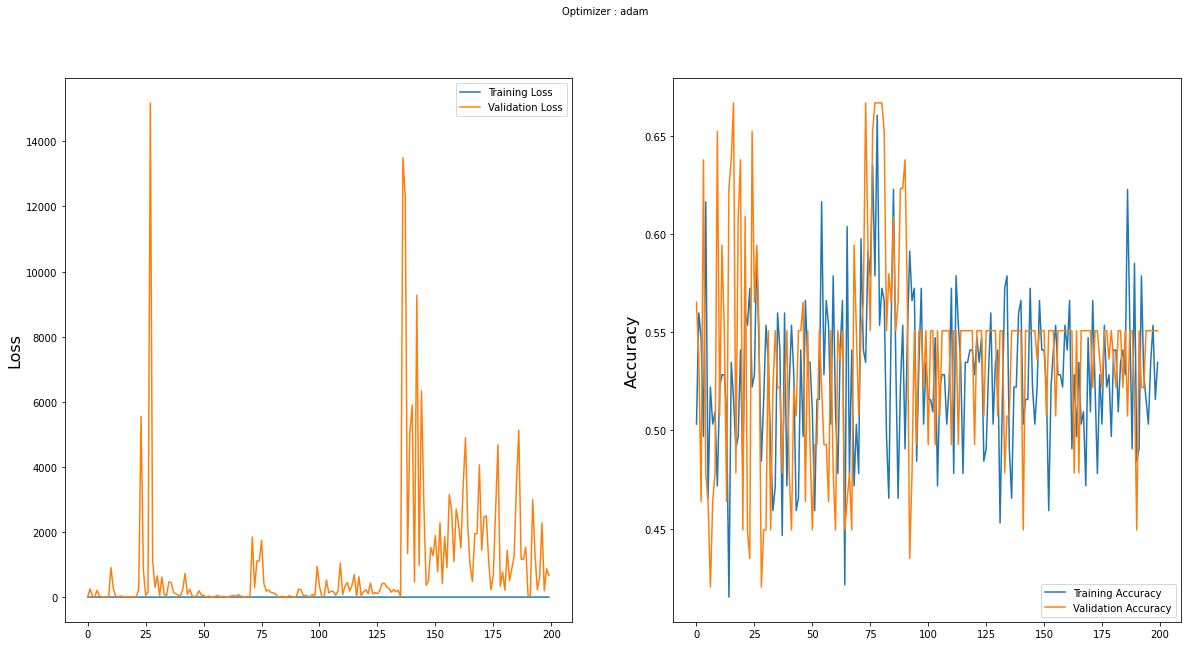

In [32]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# EfficientNetB7

In [33]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
eff = EfficientNetB7(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [34]:
x1= Flatten()(eff.output)
prediction1 = Dense(2, activation='softmax')(x1)
model6 = Model(inputs = eff.inputs, outputs = prediction1)
model6.summary()
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [35]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/200
80/80 [==============================] - 71s 636ms/step - loss: 2.9022 - accuracy: 0.5157 - f1_m: 0.5188 - precision_m: 0.5188 - recall_m: 0.5188 - val_loss: 1.5622 - val_accuracy: 0.4493 - val_f1_m: 0.4571 - val_precision_m: 0.4571 - val_recall_m: 0.4571
Epoch 2/200
80/80 [==============================] - 44s 546ms/step - loss: 1.8919 - accuracy: 0.5157 - f1_m: 0.5188 - precision_m: 0.5188 - recall_m: 0.5188 - val_loss: 1.1013 - val_accuracy: 0.4493 - val_f1_m: 0.4571 - val_precision_m: 0.4571 - val_recall_m: 0.4571
Epoch 3/200
80/80 [==============================] - 44s 546ms/step - loss: 1.3719 - accuracy: 0.4906 - f1_m: 0.4938 - precision_m: 0.4938 - recall_m: 0.4938 - val_loss: 1.0598 - val_accuracy: 0.5507 - val_f1_m: 0.5571 - val_precision_m: 0.5571 - val_recall_m: 0.5571
Epoch 4/200
80/80 [==============================] - 44s 549ms/step - loss: 1.9789 - accuracy: 0.5094 - f1_m: 0.5125 - precision_m: 0.5125 - recall_m: 0.5125 - val_loss: 0.7010 - val_accuracy: 0.4

In [30]:
eff_acc = hist6.history["val_accuracy"][24]
eff_prec = hist6.history["val_precision_m"][24]
eff_rec = hist6.history["val_recall_m"][24]
eff_f1 = hist6.history["val_f1_m"][24]

In [31]:
storeResults('EfficientNetB7',eff_acc,eff_prec,eff_rec,eff_f1)

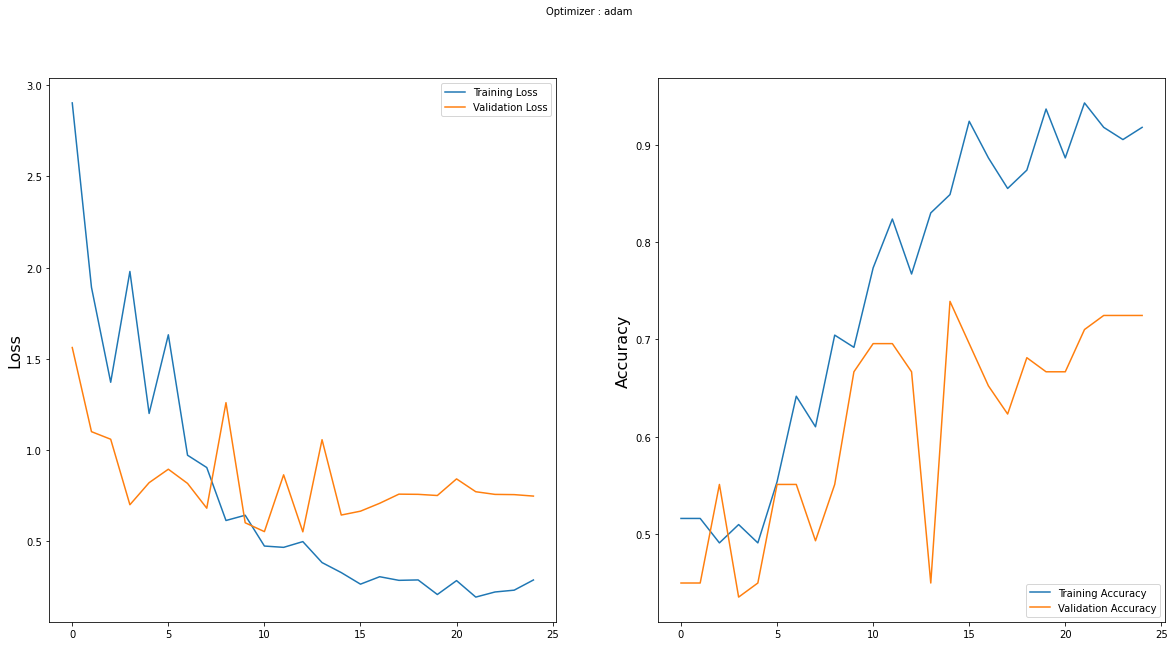

In [36]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# POXNET22 with InceptionV3

In [10]:
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [11]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape = IMAGE_SIZE + [3])

In [12]:
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(2, 
                    activation='softmax'))

In [13]:
from tensorflow.keras import optimizers, losses, activations, models

In [14]:
model7 = add_model
model7.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy',f1_m,precision_m, recall_m])
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
hist7 = model7.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/200
80/80 [==============================] - 14s 84ms/step - loss: 1.6504 - accuracy: 0.5409 - f1_m: 0.5375 - precision_m: 0.5375 - recall_m: 0.5375 - val_loss: 1.4168 - val_accuracy: 0.5660 - val_f1_m: 0.5688 - val_precision_m: 0.5688 - val_recall_m: 0.5688
Epoch 2/200
80/80 [==============================] - 4s 49ms/step - loss: 1.2333 - accuracy: 0.6730 - f1_m: 0.6750 - precision_m: 0.6750 - recall_m: 0.6750 - val_loss: 0.9229 - val_accuracy: 0.6981 - val_f1_m: 0.6938 - val_precision_m: 0.6938 - val_recall_m: 0.6938
Epoch 3/200
80/80 [==============================] - 4s 49ms/step - loss: 1.0287 - accuracy: 0.6855 - f1_m: 0.6875 - precision_m: 0.6875 - recall_m: 0.6875 - val_loss: 0.4015 - val_accuracy: 0.8428 - val_f1_m: 0.8438 - val_precision_m: 0.8438 - val_recall_m: 0.8438
Epoch 4/200
80/80 [==============================] - 4s 48ms/step - loss: 0.7948 - accuracy: 0.7233 - f1_m: 0.7250 - precision_m: 0.7250 - recall_m: 0.7250 - val_loss: 0.5195 - val_accuracy: 0.8176 - v

Epoch 32/200
80/80 [==============================] - 5s 63ms/step - loss: 0.3159 - accuracy: 0.9057 - f1_m: 0.9000 - precision_m: 0.9000 - recall_m: 0.9000 - val_loss: 0.2967 - val_accuracy: 0.8868 - val_f1_m: 0.8875 - val_precision_m: 0.8875 - val_recall_m: 0.8875
Epoch 33/200
80/80 [==============================] - 6s 72ms/step - loss: 0.3269 - accuracy: 0.9057 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - val_loss: 0.0849 - val_accuracy: 0.9811 - val_f1_m: 0.9812 - val_precision_m: 0.9812 - val_recall_m: 0.9812
Epoch 34/200
80/80 [==============================] - 5s 59ms/step - loss: 0.3323 - accuracy: 0.8994 - f1_m: 0.9000 - precision_m: 0.9000 - recall_m: 0.9000 - val_loss: 0.1344 - val_accuracy: 0.9560 - val_f1_m: 0.9563 - val_precision_m: 0.9563 - val_recall_m: 0.9563
Epoch 35/200
80/80 [==============================] - 6s 78ms/step - loss: 0.4062 - accuracy: 0.8553 - f1_m: 0.8562 - precision_m: 0.8562 - recall_m: 0.8562 - val_loss: 0.1128 - val_accuracy: 0.9623 

Epoch 63/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2842 - accuracy: 0.8742 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 0.1101 - val_accuracy: 0.9748 - val_f1_m: 0.9750 - val_precision_m: 0.9750 - val_recall_m: 0.9750
Epoch 64/200
80/80 [==============================] - 5s 59ms/step - loss: 0.3930 - accuracy: 0.8679 - f1_m: 0.8687 - precision_m: 0.8687 - recall_m: 0.8687 - val_loss: 0.0704 - val_accuracy: 0.9623 - val_f1_m: 0.9625 - val_precision_m: 0.9625 - val_recall_m: 0.9625
Epoch 65/200
80/80 [==============================] - 5s 63ms/step - loss: 0.2072 - accuracy: 0.9308 - f1_m: 0.9312 - precision_m: 0.9312 - recall_m: 0.9312 - val_loss: 0.0957 - val_accuracy: 0.9748 - val_f1_m: 0.9750 - val_precision_m: 0.9750 - val_recall_m: 0.9750
Epoch 66/200
80/80 [==============================] - 5s 64ms/step - loss: 0.3125 - accuracy: 0.8931 - f1_m: 0.8938 - precision_m: 0.8938 - recall_m: 0.8938 - val_loss: 0.0746 - val_accuracy: 0.9748 

Epoch 94/200
80/80 [==============================] - 5s 68ms/step - loss: 0.2731 - accuracy: 0.9057 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - val_loss: 0.1271 - val_accuracy: 0.9623 - val_f1_m: 0.9625 - val_precision_m: 0.9625 - val_recall_m: 0.9625
Epoch 95/200
80/80 [==============================] - 6s 74ms/step - loss: 0.1718 - accuracy: 0.9308 - f1_m: 0.9312 - precision_m: 0.9312 - recall_m: 0.9312 - val_loss: 0.0700 - val_accuracy: 0.9623 - val_f1_m: 0.9625 - val_precision_m: 0.9625 - val_recall_m: 0.9625
Epoch 96/200
80/80 [==============================] - 5s 69ms/step - loss: 0.2454 - accuracy: 0.9057 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - val_loss: 0.1139 - val_accuracy: 0.9497 - val_f1_m: 0.9500 - val_precision_m: 0.9500 - val_recall_m: 0.9500
Epoch 97/200
80/80 [==============================] - 4s 55ms/step - loss: 0.3209 - accuracy: 0.8868 - f1_m: 0.8875 - precision_m: 0.8875 - recall_m: 0.8875 - val_loss: 0.0516 - val_accuracy: 0.9811 

Epoch 125/200
80/80 [==============================] - 5s 68ms/step - loss: 0.2181 - accuracy: 0.9308 - f1_m: 0.9250 - precision_m: 0.9250 - recall_m: 0.9250 - val_loss: 0.2161 - val_accuracy: 0.9371 - val_f1_m: 0.9375 - val_precision_m: 0.9375 - val_recall_m: 0.9375
Epoch 126/200
80/80 [==============================] - 6s 75ms/step - loss: 0.1757 - accuracy: 0.9371 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375 - val_loss: 0.0550 - val_accuracy: 0.9748 - val_f1_m: 0.9750 - val_precision_m: 0.9750 - val_recall_m: 0.9750
Epoch 127/200
80/80 [==============================] - 7s 82ms/step - loss: 0.2357 - accuracy: 0.9245 - f1_m: 0.9250 - precision_m: 0.9250 - recall_m: 0.9250 - val_loss: 0.0429 - val_accuracy: 0.9811 - val_f1_m: 0.9812 - val_precision_m: 0.9812 - val_recall_m: 0.9812
Epoch 128/200
80/80 [==============================] - 5s 69ms/step - loss: 0.1685 - accuracy: 0.9245 - f1_m: 0.9250 - precision_m: 0.9250 - recall_m: 0.9250 - val_loss: 0.0229 - val_accuracy: 0.9

Epoch 186/200
80/80 [==============================] - 5s 68ms/step - loss: 0.3422 - accuracy: 0.9119 - f1_m: 0.9125 - precision_m: 0.9125 - recall_m: 0.9125 - val_loss: 0.0460 - val_accuracy: 0.9874 - val_f1_m: 0.9875 - val_precision_m: 0.9875 - val_recall_m: 0.9875
Epoch 187/200
80/80 [==============================] - 5s 60ms/step - loss: 0.2543 - accuracy: 0.9434 - f1_m: 0.9438 - precision_m: 0.9438 - recall_m: 0.9438 - val_loss: 0.1055 - val_accuracy: 0.9560 - val_f1_m: 0.9500 - val_precision_m: 0.9500 - val_recall_m: 0.9500
Epoch 188/200
80/80 [==============================] - 5s 59ms/step - loss: 0.1696 - accuracy: 0.9371 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375 - val_loss: 0.0550 - val_accuracy: 0.9874 - val_f1_m: 0.9875 - val_precision_m: 0.9875 - val_recall_m: 0.9875
Epoch 189/200
80/80 [==============================] - 5s 65ms/step - loss: 0.2153 - accuracy: 0.9434 - f1_m: 0.9438 - precision_m: 0.9438 - recall_m: 0.9438 - val_loss: 0.0435 - val_accuracy: 0.9

In [32]:
poxnet_acc = hist7.history["val_accuracy"][199]
poxnet_prec = hist7.history["val_precision_m"][199]
poxnet_rec = hist7.history["val_recall_m"][199]
poxnet_f1 = hist7.history["val_f1_m"][199]

In [33]:
storeResults('PoxNet22-InceptionV3',poxnet_acc,poxnet_prec,poxnet_rec,poxnet_f1)

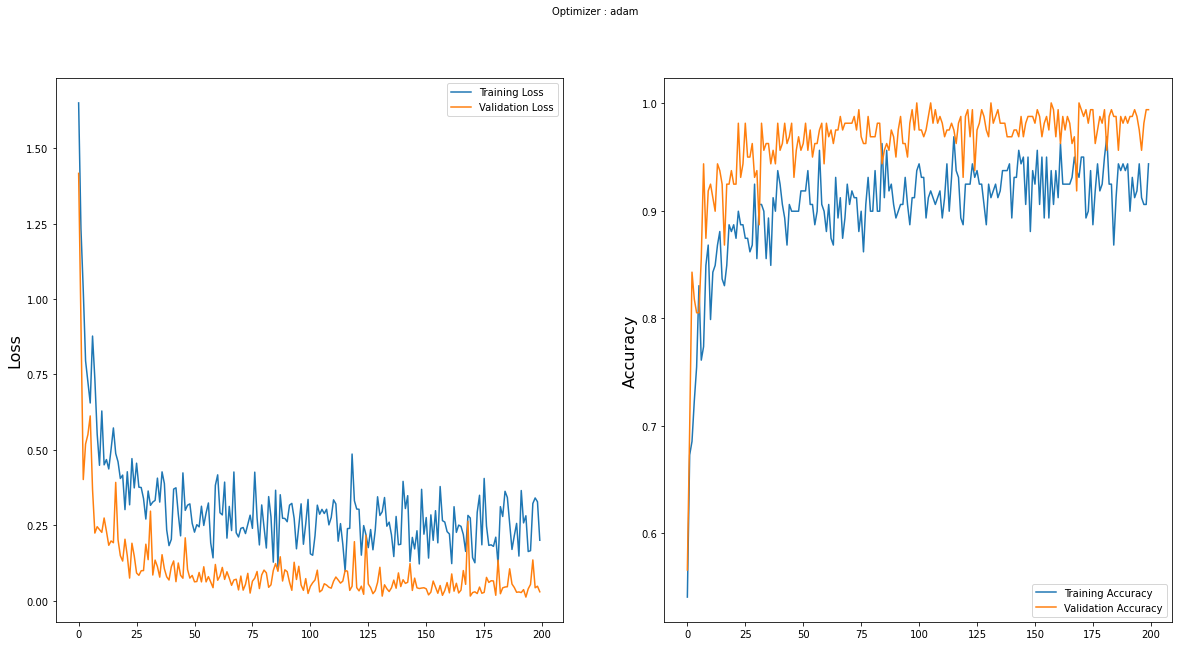

In [16]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
model7.save('model.h5')

# Comparison

In [34]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                        
                        
                      })

In [35]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResNet50,0.500,0.500,0.500,0.500
1,VGG16,0.551,0.557,0.557,0.557
2,Inception ResNetV2,0.580,0.571,0.571,0.571
3,DenseNet201,0.681,0.671,0.671,0.671
4,InceptionV3,0.551,0.557,0.557,0.557
5,EfficientNetB7,0.725,0.729,0.729,0.729
6,PoxNet22-InceptionV3,0.994,0.994,0.994,0.994


# Graph

In [18]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

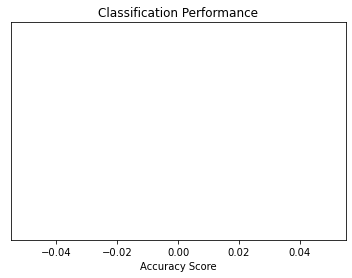

In [19]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

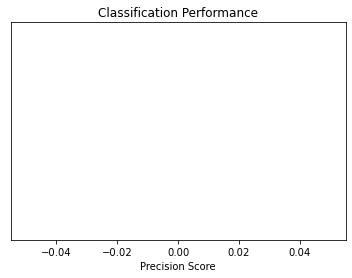

In [20]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

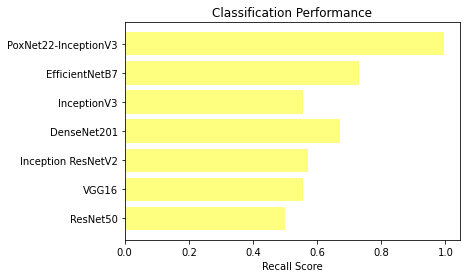

In [39]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

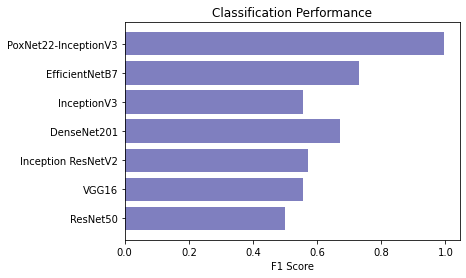

In [40]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

In [41]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()